In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load the crime data from the city of Buenos Aires of 2021

In [3]:
#load the buenos aires crime dataset of 2021
df = pd.read_csv('C:\\Users\\nicor\\OneDrive\\Documentos\\Python\\Datacamp\\ML fun ride\\buenos_aires_crime_2021.csv',sep=';')

### Data Exploration

In [4]:
#short EDA on the dataset
df.head()

,id-mapa,anio,mes,dia,fecha,franja,tipo,subtipo,uso_armas,barrio,comuna,latitud,longitud,cantidad
0,HC-2021-1008202,2021,Enero,Miércoles,06/01/2021,18,Homicidio,Siniestro Vial,NaN,Constitución,1.0,"-34,62761","-58,379146",1.0
1,HC-2021-1009094,2021,Enero,Jueves,07/01/2021,10,Homicidio,Siniestro Vial,NaN,Mataderos,9.0,"-34,64972969","-58,51058958",1.0
2,HC-2021-1013236,2021,Enero,Domingo,10/01/2021,7,Homicidio,Siniestro Vial,NaN,Parque Chacabuco,7.0,"-34,62917196","-58,43058079",1.0
3,HC-2021-1014154,2021,Enero,Lunes,11/01/2021,9,Homicidio,Siniestro Vial,NaN,Nueva Pompeya,5.0,"-34,63867577","-58,4145554",1.0
4,HC-2021-1015476,2021,Enero,Lunes,11/01/2021,21,Homicidio,Siniestro Vial,NaN,Parque Avellaneda,9.0,"-34,64771436","-58,46806552",1.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88567 entries, 0 to 88566
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id-mapa    88567 non-null  object 
 1   anio       88567 non-null  int64  
 2   mes        88567 non-null  object 
 3   dia        88567 non-null  object 
 4   fecha      88567 non-null  object 
 5   franja     88567 non-null  object 
 6   tipo       88567 non-null  object 
 7   subtipo    16321 non-null  object 
 8   uso_armas  8472 non-null   object 
 9   barrio     87390 non-null  object 
 10  comuna     87907 non-null  float64
 11  latitud    88567 non-null  object 
 12  longitud   88567 non-null  object 
 13  cantidad   7299 non-null   float64
dtypes: float64(2), int64(1), object(11)
memory usage: 9.5+ MB


In [6]:
df.describe()

,anio,comuna,cantidad
count,88567.0,87907.000000,7299.000000
mean,2021.0,7.538899,1.158515
std,0.0,4.554293,0.557664
min,2021.0,0.000000,1.000000
25%,2021.0,4.000000,1.000000
50%,2021.0,7.000000,1.000000
75%,2021.0,12.000000,1.000000
max,2021.0,15.000000,10.000000


C:\Users\nicor\anaconda3\envs\mne3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


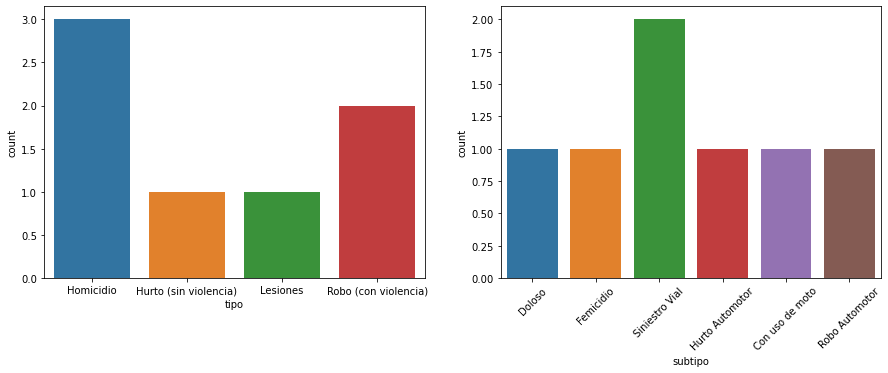

In [7]:
#see the quantity of each type of crime in the dataset
df_g = df.groupby(['tipo','subtipo']).agg(cantidad = pd.NamedAgg(column='cantidad', aggfunc='sum')).reset_index()

#plot the quantity of each type of crime
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(x='tipo', data=df_g , ax=ax[0])
sns.countplot(x='subtipo', data=df_g , ax=ax[1])
plt.xticks(rotation=45)
fig.show()

### dataset preparation
we will be trying to estimate, according to the area of the city which type of crime is more probable to happen

In [8]:
#for kmeans we will be using tipo as target variable and uso_armas,barrio,comuna,franja as predictors
df_kmeans = df.copy(deep=True)
df_kmeans = df_kmeans[['tipo','uso_armas','barrio','comuna','franja']]

#deal with missing values
df_kmeans['uso_armas'].fillna(0, inplace=True)

print(df_kmeans.isnull().sum())
df_kmeans = df_kmeans.dropna()

#see the shape of the dataset before and after the missing values treatment
print(f'\nThe quantity of rows before {df.shape[0]} and after {df_kmeans.shape[0]} the missing values treatment')

tipo            0
uso_armas       0
barrio       1177
comuna        660
franja          0
dtype: int64

The quantity of rows before 88567 and after 87390 the missing values treatment


In [9]:
#convert the categorical variables to numerical
df_kmeans['uso_armas'] = df_kmeans['uso_armas'].astype('category')

#2: Arma de fuego , 1: Arma cortante, 0: No usa arma
df_kmeans['uso_armas'] = df_kmeans['uso_armas'].cat.codes

##### Encoding categorical data
using OneHotEncoding would not be making much sense as it would create like 50 new columns

In [23]:
#Using sckit-learn's LabelEncoder for the barrio categorical feature
from sklearn.preprocessing import LabelEncoder

# Set up the LabelEncoder object
enc = LabelEncoder()

#Apply the encoding to the categorical features
df_kmeans['barrio_enc'] = enc.fit_transform(df_kmeans['barrio'])

In [28]:
# Compare the two columns (sckit label encoder)
print(df_kmeans[['barrio','barrio_enc']].head())

              barrio  barrio_enc
0       Constitución          11
1          Mataderos          15
2   Parque Chacabuco          23
3      Nueva Pompeya          18
4  Parque Avellaneda          22


In [42]:
print()
df_kmeans.comuna.value_counts()

1.0     9447
4.0     7796
14.0    7785
3.0     7579
7.0     6767
8.0     5713
13.0    5670
9.0     5203
15.0    5116
5.0     5019
12.0    4707
2.0     4397
10.0    4225
6.0     4047
11.0    3919
Name: comuna, dtype: int64

### K-Means ###

In [11]:
# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

In [39]:
# Create arrays for the features and the response variable
x = df_kmeans.drop(['tipo','barrio'], axis=1).values
y = df_kmeans['tipo'].values

In [30]:
# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors = 6)

In [40]:
# Fit the classifier to the data
knn.fit(x,y)

ValueError: could not convert string to float: 'SD'